# Capsone Project-- speaker verification

Zhihong Zhang

# Set up

For this project, I would like to mainly use pytorch lighting to deal with the model for itsd simplicity and 

After setting up, the code will be seperated into following section  
1. Research code:  the LightningModule

2.  Engineering code: Trainer

3. Non-essential : Callbacks

4. Data: LightningDataModule


In [1]:
#using lighting model
!pip install pytorch-lightning

     |████████████████████████████████| 563kB 5.2MB/s 
     |████████████████████████████████| 829kB 7.6MB/s 
     |████████████████████████████████| 276kB 11.0MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=d9cd756ba2bc9184b46aaeaae186219da1d1b657a5056e2ecc64efa466b40b72
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=586f8fcbc74753fca7e037fa2732a17603f7638cb6d1a042a7f8b9ef5797ea7d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unins

In [3]:
#for lighting model work properly
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

In [4]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
## use for the version control 
#! ls lighting_logs/version_6/checkpoints

In [2]:
!pip install spectrum

     |████████████████████████████████| 235kB 5.7MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp36-cp36m-linux_x86_64.whl size=234764 sha256=1f7cab50e6c0f48731f899c29195b95d1f81f79568ecb2aed845e292e7c78e98
  Stored in directory: /root/.cache/pip/wheels/62/de/fd/94dc5ad0a7d93803f4cb4a26744d21e91ac4bf0a63004d2b14
Successfully built spectrum


## use plp

plp code:
https://github.com/mystlee/rasta_py/blob/master/rasta.py

In [ ]:
import librosa
import librosa.filters
import scipy
import scipy.fftpack as fft
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import spectrum

#work for plp
def rastaplp(x, fs = 16000, win_time = 0.040, hop_time = 0.020, dorasta = True, modelorder = 8):
    # first compute power spectrum
    p_spectrum, _ = powspec(x, fs, win_time, hop_time)
    # next group to critical bands
    aspectrum = audspec(p_spectrum, fs)
    nbands = aspectrum.shape[0]
    
    if dorasta:
        # put in log domain
        nl_aspectrum = np.log(aspectrum)
        # next do rasta filtering
        ras_nl_aspectrum = rastafilt(nl_aspectrum)
        # do inverse log
        aspectrum = np.exp(ras_nl_aspectrum)
    
    postspectrum, _ = postaud(aspectrum, fs / 2)
    
    lpcas = dolpc(postspectrum, modelorder);
    cepstra = lpc2cep(lpcas, modelorder + 1);
    
    if modelorder > 0:
        lpcas = dolpc(postspectrum, modelorder);
        cepstra = lpc2cep(lpcas, modelorder + 1);
        spectra,F,M = lpc2spec(lpcas, nbands);
    else:
        spectra = postspectrum
        cepstra = spec2cep(spectra)
    
    cepstra = lifter(cepstra, 0.6)
    
    return cepstra

def powspec(x, fs = 16000, window_time = 0.040, hop_time = 0.020, dither = 1):
    win_length = int(np.round(window_time * fs))
    hop_length = int(np.round(hop_time * fs))
    fft_length = int(np.power(2, np.ceil(np.log2(window_time * fs))))
    
    X = librosa.stft(np.multiply(32768, x), n_fft = fft_length, hop_length = hop_length, 
                     win_length = win_length, window='hann', center = False)
    pow_X = np.power(np.abs(X), 2)
    if dither:
        pow_X = np.add(pow_X, win_length)
    e = np.log(np.sum(pow_X, axis = 0))
    return pow_X, e

def hz2bark(f):
    z = np.multiply(6, np.arcsinh(np.divide(f, 600)))
    return z

def bark2hz(z):
    hz = np.multiply(600, np.sinh(np.divide(z, 6)))
    return hz

def fft2barkmx(fft_length, fs, nfilts = 0, band_width = 1, min_freq = 0, max_freq = 0):
    if max_freq == 0:
        max_freq = fs / 2
        
    min_bark = hz2bark(min_freq)
    nyqbark = hz2bark(max_freq) - min_bark
    
    if nfilts == 0 :
        nfilts = np.add(np.ceil(nyqbark), 1)
    
    wts = np.zeros((int(nfilts), int(fft_length)))
    step_barks = np.divide(nyqbark, np.subtract(nfilts, 1))
    binbarks = hz2bark(np.multiply(np.arange(0, np.add(np.divide(fft_length, 2),1)), np.divide(fs, fft_length)))
    
    for i in range (int(nfilts)):
        f_bark_mid = min_bark + np.multiply(i, step_barks)
        lof = np.subtract(np.subtract(binbarks, f_bark_mid), 0.5)
        hif = np.add(np.subtract(binbarks, f_bark_mid), 0.5)
        wts[i, 0 : int(fft_length / 2) + 1] = np.power(10, np.minimum(0, np.divide(np.minimum(hif, np.multiply(-2.5, lof)), band_width)))
    return wts

def rastafilt(x):
    numer = np.arange(-2, 3)
    numer = np.divide(-numer, np.sum(np.multiply(numer, numer)))
    denom = np.array([1, -0.94])
    
    zi = signal.lfilter_zi(numer,1)
    y = np.zeros((x.shape))
    for i in range(x.shape[0]):
        y1, zi = signal.lfilter(numer, 1, x[i, 0:4], axis = 0, zi = zi * x[i, 0])
        y1 = y1*0
        y2, _ = signal.lfilter(numer, denom, x[i, 4:x.shape[1]], axis = 0, zi = zi)
        y[i, :] = np.append(y1, y2)    
    return y


def dolpc(x, modelorder = 8):
    nbands, nframes = x.shape
    ncorr = 2 * (nbands - 1)
    R = np.zeros((ncorr, nframes))
    
    R[0:nbands, :] = x
    for i in range(nbands - 1):
        R[i + nbands - 1, :] = x[nbands - (i + 1), :]
    
    r = fft.ifft(R.T).real.T
    r = r[0:nbands, :]
    
    y = np.ones((nframes, modelorder + 1))
    e = np.zeros((nframes, 1))
    
    if modelorder == 0:
        for i in range(nframes):
            _ , e_tmp, _ = spectrum.LEVINSON(r[:, i], modelorder, allow_singularity = True)
            e[i, 0] = e_tmp
    else:
        for i in range(nframes):
            y_tmp, e_tmp, _ = spectrum.LEVINSON(r[:, i], modelorder, allow_singularity = True)
            y[i, 1:modelorder + 1] = y_tmp
            e[i, 0] = e_tmp
    
    y = np.divide(y.T, np.add(np.tile(e.T, (modelorder + 1, 1)), 1e-8))
    
    return y

def lpc2cep(a, nout = 0):
    nin, ncol = a.shape
    
    order = nin - 1
    
    if nout == 0:
        nout = order + 1
        
    cep = np.zeros((nout, ncol))
    cep[0, :] = -np.log(a[0, :])
    
    norm_a = np.divide(a, np.add(np.tile(a[0, :], (nin, 1)), 1e-8))
    
    for n in range(1, nout):
        sum = 0
        for m in range(1, n):
            sum = np.add(sum, np.multiply(np.multiply((n - m), norm_a[m, :]), cep[(n - m), :]))
        
        cep[n, :] = -np.add(norm_a[n, :], np.divide(sum, n))
    
    return cep

def lifter(x, lift = 0.6, invs = False):
    ncep = x.shape[0]
    
    if lift == 0:
        y = x
    else:
        if lift < 0:
            warnings.warn('HTK liftering does not support yet; default liftering')
            lift = 0.6
        liftwts = np.power(np.arange(1, ncep), lift)
        liftwts = np.append(1, liftwts)
        
        if (invs):
            liftwts = np.divide(1, liftwts)
        
        y = np.matmul(np.diag(liftwts), x)
    
    return y

def melfcc(x, fs = 16000, min_freq = 50, max_freq = 6500, n_mfcc = 13, n_bands = 40, lifterexp = 0.6,
          fbtype = 'fcmel', dcttype = 1, usecmp = True, window_time = 0.040, hop_time = 0.020,
          preemph = 0.97, dither = 1, sumpower = 1, band_width = 1, modelorder = 0,
           broaden = 0, useenergy = False):
    
    if preemph != 0:
        b = [1, -preemph]
        a = 1
        x = signal.lfilter(b, a, x)
        
    pspectrum, logE = powspec(x, fs = fs, window_time = window_time, hop_time = hop_time, dither = dither)
    aspectrum = audspec(pspectrum, fs = fs, nfilts = n_bands, fbtype = fbtype, 
                        min_freq = min_freq, max_freq = max_freq)
    
    if usecmp:
        aspectrum, _ = postaud(aspectrum, fmax = max_freq, fbtype = fbtype)
    
    if modelorder > 0:
        lpcas = dolpc(aspectrum, modelorder)
        cepstra = lpc2cep(lpcas, nout = n_mfcc)

    else:
        cepstra, _ = spec2cep(aspectrum, ncep = n_mfcc, dcttype = dcttype)
        
    cepstra = lifter(cepstra, lift = lifterexp);
    
    if useenergy == True:
        cepstra[0, :] = logE
    
    return cepstra


def hz2mel(f, htk = False):
    if htk:
        z = np.multiply(2595, np.log10(np.add(1, np.divide(f, 700))))
    else:
        f_0 = 0.0
        f_sp = 200 / 3
        brkfrq = 1000
        brkpt = (brkfrq - f_0) / f_sp
        logstep = np.exp(np.log(6.4) / 27.0)
        
        f = np.array(f, ndmin = 1)
        z = np.zeros((f.shape[0], ))
        
        for i in range(f.shape[0]):
            if f[i] < brkpt:
                z[i] = (f[i] - f_0) / f_sp
            else:
                z[i] = brkpt + (np.log(f[i] / brkfrq) / np.log(logstep))
    return z

def mel2hz(z, htk = False):
    if htk:
        f = np.multiply(700, np.subtract(np.power(10, np.divide(z, 2595)), 1))
    else:
        f_0 = 0
        f_sp = 200/3
        brkfrq = 1000
        brkpt = (brkfrq - f_0) / f_sp
        logstep = np.exp(np.log(6.4) / 27.0)
        
        z = np.array(z, ndmin = 1)
        f = np.zeros((z.shape[0], ))
        
        for i in range(z.shape[0]):
            if z[i] < brkpt:
                f[i] = f_0 + f_sp * z[i]
            else:
                f[i] = brkfrq * np.exp(np.log(logstep) * (z[i] - brkpt))
    return f

def fft2melmx(fft_length, fs, nfilts = 0, band_width = 1, min_freq = 0, max_freq = 0, 
              htk = False, constamp = False):
    if nfilts == 0 :
        nfilts = np.ceil(hz2mel(max_freq, htk) / 2)
    if max_freq == 0:
        max_freq = fs / 2
        
    wts = np.zeros((int(nfilts), int(fft_length)))
    fftfrqs = np.multiply(np.divide(np.arange(0,fft_length / 2 + 1), fft_length), fs)
    
    min_mel = hz2mel(min_freq, htk)
    max_mel = hz2mel(max_freq, htk)
    binfrqs = mel2hz(np.add(min_mel, np.multiply(np.arange(0, nfilts + 2),
                                                 (max_mel - min_mel) / (nfilts + 1))), htk)

    for i in range (int(nfilts)):
        fs_tmp = binfrqs[np.add(np.arange(0,3), i)]
        fs_tmp = np.add(fs_tmp[1], np.multiply(band_width, np.subtract(fs_tmp, fs_tmp[1])))
        loslope = np.divide(np.subtract(fftfrqs, fs_tmp[0]), np.subtract(fs_tmp[1], fs_tmp[0]))
        hislope = np.divide(np.subtract(fs_tmp[2], fftfrqs), np.subtract(fs_tmp[2], fs_tmp[1]))
        wts[i, 0 : int(fft_length / 2) + 1] = np.maximum(0, np.minimum(loslope, hislope))
    
    if constamp == False:
        wts = np.matmul(np.diag(np.divide(2, np.subtract(binfrqs[2 : int(nfilts) + 2],
                                                         binfrqs[0 : int(nfilts)]))), wts)
    
    return wts

def audspec(p_spectrum, fs = 16000, nfilts = 0, fbtype = 'bark', 
            min_freq = 0, max_freq = 0, sumpower = 1, band_width = 1):
    if nfilts == 0:
        np.add(np.ceil(hz2bark(fs / 2)), 1)
    if max_freq == 0:
        max_freq = fs / 2
    nfreqs = p_spectrum.shape[0]
    nfft = (int(nfreqs) - 1) * 2
    
    if fbtype == 'bark':
        wts = fft2barkmx(nfft, fs, nfilts, band_width, min_freq, max_freq)
    elif fbtype == 'mel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq)
    elif fbtype == 'htkmel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq, htk = True, constamp = True)
    elif fbtype == 'fcmel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq, htk = True, constamp = False)
        
    wts = wts[:, 0 : nfreqs]
    
    if sumpower:
        aspectrum = np.matmul(wts, p_spectrum)
    else:
        aspectrum = np.power(np.matmul(wts, np.sqrt(p_spectrum)), 2)
    return aspectrum

def postaud(x, fmax, fbtype = 'bark', broaden = 0):
    nbands, nframes = x.shape
    nfpts = int(nbands + 2 * broaden)
    
    if fbtype == 'bark':
        bandcfhz = bark2hz(np.linspace(0, hz2bark(fmax), nfpts))
    elif fbtype == 'mel':
        bandcfhz = mel2hz(np.linspace(0, hz2mel(fmax), nfpts))
    elif fbtype == 'htkmel' or fbtype == 'fcmel':
        bandcfhz = mel2hz(np.linspace(0, hz2mel(fmax, htk = True), nfpts), htk = True)
        
    bandcfhz = bandcfhz[broaden : (nfpts - broaden)];
    
    fsq = np.power(bandcfhz, 2)
    ftmp = np.add(fsq, 1.6e5)
    eql = np.multiply(np.power(np.divide(fsq, ftmp), 2), np.divide(np.add(fsq, 1.44e6), np.add(fsq, 9.61e6)))
    
    z = np.multiply(np.tile(eql, (nframes, 1)).T, x)
    z = np.power(z, 0.33)
    
    if broaden:
        y = np.zeros((z.shape[0] + 2, z.shape[1]))
        y[0, :] = z[0, :]
        y[1:nbands + 1, :] = z
        y[nbands + 1, :] = z[z.shape[0] - 1, :]
    else:
        y = np.zeros((z.shape[0], z.shape[1]))
        y[0, :] = z[1, :]
        y[1:nbands - 1, :] = z[1:z.shape[0] - 1, :]
        y[nbands - 1, :] = z[z.shape[0] - 2, :]
    
    return y, eql

def spec2cep(spec, ncep, dcttype):
    nrow, ncol = spec.shape[0], spec.shape[1]
    dctm = np.zeros((ncep, nrow))
    
    if dcttype == 2 or dcttype == 3:
        for i in range(ncep):
            dctm[i, :] = np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(1, 2 * nrow, 2)), (2 * nrow)), np.pi)), np.sqrt(2 / nrow))
        
        if dcttype == 2:
            dctm[0, :] = np.divide(dctm[0, :], np.sqrt(2))
            
    elif dcttype == 4:
        for i in range(ncep):
            dctm[i, :] = np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(1, nrow + 1)), (nrow + 1)), np.pi)), 2)
            dctm[i, 0] = np.add(dctm[i, 0], 1)
            dctm[i, int(nrow - 1)] = np.multiply(dctm[i, int(nrow - 1)], np.power(-1, i))
        dctm = np.divide(dctm, 2 * (nrow + 1))
    
    else:
        for i in range(ncep):
            dctm[i, :] = np.divide(np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(0, nrow)), (nrow - 1)), np.pi)), 2), 2 * (nrow - 1))
        dctm[:, 0] = np.divide(dctm[:, 0], 2)
        dctm[:, int(nrow - 1)] = np.divide(dctm[:, int(nrow - 1)], 2)
    
    cep = np.matmul(dctm, np.log(np.add(spec, 1e-8)))
    
    return cep, dctm

def lpc2spec(lpcas, nout = 17, FMout = False):
    
    rows, cols = lpcas.shape
    order = rows - 1
    
    gg = lpcas[0, :]
    aa = np.divide(lpcas, np.tile(gg, (rows, 1)))
    
#    Calculate the actual z-plane polyvals: nout points around unit circle
    tmp_1 = np.array(np.arange(0, nout), ndmin = 2).T
    tmp_1 = np.divide(np.multiply(-1j, np.multiply(tmp_1, np.pi)), (nout - 1))
    tmp_2 = np.array(np.arange(0, order + 1), ndmin = 2)
    zz = np.exp(np.matmul(tmp_1, tmp_2))
#    Actual polyvals, in power (mag^2)    
    features = np.divide(np.power(np.divide(1, np.abs(np.matmul(zz, aa))), 2), np.tile(gg, (nout, 1)))
    F = np.zeros((cols, int(np.ceil(rows / 2))))
    M = F
    
    if FMout == True:
        for c in range(cols):
            aaa = aa[:, c]
            rr = np.roots(aaa)
            ff_tmp = np.angle(rr)
            ff = np.array(ff_tmp, ndmin = 2).T
            zz = np.exp(np.multiply(1j, np.matmul(ff, np.array(np.arange(0, aaa.shape[0]), ndmin = 2))))
            mags = np.sqrt(np.divide(np.power(np.divide(1, np.abs(np.matmul(zz, np.array(aaa, ndmin = 2).T))), 2), gg[c]))
            
            ix = np.argsort(ff_tmp)
            dummy = np.sort(ff_tmp)
            mp_F_list = []
            tmp_M_list = []
            
            for i in range(ff.shape[0]):
                if dummy[i] > 0:
                    tmp_F_list = np.append(tmp_F_list, dummy[i])
                    tmp_M_list = np.append(tmp_M_list, mags[ix[i]])
            
            M[c, 0 : tmp_M_list.shape[0]] = tmp_M_list
            F[c, 0 : tmp_F_list.shape[0]] = tmp_F_list
        
    return features, F, M

def deltas(x, w = 9):
    rows, cols = x.shape
    hlen = np.floor(w / 2)
    win = np.arange(hlen,-(hlen + 1),-1, dtype = 'float32')

    xx = np.append(np.append(np.tile(x[:, 0], (int(hlen), 1)).T, x, axis = 1), 
               np.tile(x[:, cols - 1], (int(hlen), 1)).T, axis = 1)
    
    d = signal.lfilter(win, 1, xx, axis = 1)
    d = d[:, int(2 * hlen) : int(2 * hlen + cols)]
    return d

def cep2spec(cep, nfreq, dcttype = 2):
    ncep, ncol = cep.shape
    
    dctm  = np.zeros((ncep, nfreq))
    idctm = np.zeros((nfreq, ncep))
    
    if dcttype == 2 or dcttype == 3:
        for i in range(ncep):
            dctm[i, :] = np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(1, 2 * nfreq, 2)),
                                                                  (2 * nfreq)), np.pi)), np.sqrt(2 / nfreq))        
            
        if dcttype == 2:
            dctm[0, :] = np.divide(dctm[0, :], np.sqrt(2))
        else:
            dctm[0, :] = np.divide(dctm[0, :], 2)
                
        idctm = dctm.T
        
    elif dcttype == 4:
        for i in range(ncep):
            idctm[:, i] = np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(1, nfreq + 1).T), (nfreq + 1)), np.pi)), 2)
            
        idctm[:, 0:ncep] = np.divide(idctm[:, 0:ncep], 2)    
    
    else:
        for i in range(ncep):
            idctm[:, i] = np.multiply(np.cos(np.multiply(np.divide(np.multiply(i, np.arange(0, nfreq).T), (nfreq - 1)), np.pi)), 2)
            
        idctm[:, [0, -1]] = np.divide(idctm[:, [0, -1]], 2)
        
    spec = np.exp(np.matmul(idctm, cep))
    
    return spec, idctm

def invpostaud(y, fmax, fbtype = 'bark', broaden = 0):
    
    nbands, nframes = y.shape
    
    if fbtype == 'bark':
        bandcfhz = bark2hz(np.linspace(0, hz2bark(fmax), nbands))
    elif fbtype == 'mel':
        bandcfhz = mel2hz(np.linspace(0, hz2mel(fmax), nbands))
    elif fbtype == 'htkmel' or fbtype == 'fcmel':
        bandcfhz = mel2hz(np.linspace(0, hz2mel(fmax, htk = True), nbands), htk = True)
        
    bandcfhz = bandcfhz[broaden : (nbands - broaden)]
    
    fsq = np.power(bandcfhz, 2)
    ftmp = np.add(fsq, 1.6e5)
    eql = np.multiply(np.power(np.divide(fsq, ftmp), 2), 
                      np.divide(np.add(fsq, 1.44e6), np.add(fsq, 9.61e6)))
    
    x = np.power(y, np.divide(1, 0.33))
    
    if eql[0] == 0:
        eql[0] = eql[1]
        eql[-1] = eql[-2]
        
    x = np.divide(x[broaden : (nbands - broaden + 1), :], np.add(np.tile(eql.T, (nframes, 1)).T, 1e-8))
    
    return x, eql

def invpowspec(y, fs, win_time, hop_time, excit = []):
    nrow, ncol = y.shape
    r = excit
    
    winpts = int(np.round(np.multiply(win_time, fs)))
    steppts = int(np.round(np.multiply(hop_time, fs)))
    nfft = int(np.power(2, np.ceil(np.divide(np.log(winpts), np.log(2)))))
    
    # Can't predict librosa stft length...
    tmp = librosa.istft(y, hop_length = steppts, win_length = winpts, 
                      window='hann', center = False)
    xlen = len(tmp)
    # xlen = int(np.add(winpts, np.multiply(steppts, np.subtract(ncol, 1))))
    # xlen = int(np.multiply(steppts, np.subtract(ncol, 1)))
    
    if len(r) == 0:
        r = np.squeeze(np.random.randn(xlen, 1))
    r = r[0:xlen]
    
    R = librosa.stft(np.divide(r, 32768 * 12), n_fft = nfft, hop_length = steppts,
                     win_length = winpts, window = 'hann', center = False)

    R = np.multiply(R, np.sqrt(y))
    x = librosa.istft(R, hop_length = steppts, win_length = winpts, 
                      window = 'hann', center = False)
                     
    return x

def invaudspec(aspectrum, fs = 16000, nfft = 512, fbtype = 'bark', 
               min_freq = 0, max_freq = 0, sumpower = True, band_width = 1):
    
    if max_freq == 0:
        max_freq = fs / 2
    nfilts, nframes = aspectrum.shape
    
    if fbtype == 'bark':
        wts = fft2barkmx(nfft, fs, nfilts, band_width, min_freq, max_freq)
    elif fbtype == 'mel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq)
    elif fbtype == 'htkmel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq, htk = True, constamp = True)
    elif fbtype == 'fcmel':
        wts = fft2melmx(nfft, fs, nfilts, band_width, min_freq, max_freq, htk = True, constamp = False)
    
    wts = wts[:, 0:int(nfft / 2 + 1)]
    
    ww = np.matmul(wts.T, wts)
    itws = np.divide(wts.T, np.tile(np.maximum(np.divide(np.mean(np.diag(ww)), 100), 
                                               np.sum(ww, axis = 0)), (nfilts, 1)).T)
    if sumpower == True:
        spec = np.matmul(itws, aspectrum)
    else:
        spec = np.power(np.matmul(itws, np.sqrt(aspectrum)))
   
    return spec, wts, itws

def invmelfcc(cep, fs, win_time = 0.040, hop_time = 0.020, lifterexp = 0.6, sumpower = True,
             preemph = 0.97, max_freq = 6500, min_freq = 50, n_bands = 40, band_width = 1,
             dcttype = 2, fbtype = 'mel', usecmp = False, modelorder = 0, broaden = 0, excitation = []):
    
    winpts = int(np.round(np.multiply(win_time, fs)))
    nfft = int(np.power(2, np.ceil(np.divide(np.log(winpts), np.log(2)))))
    
    cep = lifter(cep, lift = lifterexp, invs = True)
    
    pspc, _ = cep2spec(cep, nfreq = int(n_bands + 2 * broaden), dcttype = dcttype)
    
    if usecmp == True:
        aspc, _ = invpostaud(pspc, fmax = max_freq, fbtype = fbtype, broaden = broaden)
    else:
        aspc = pspc
        
    spec, _, _ = invaudspec(aspc, fs = fs, nfft = nfft, fbtype = fbtype, min_freq = min_freq,
                            max_freq = max_freq, sumpower = sumpower, band_width = band_width)
    
    x = invpowspec(spec, fs, win_time = win_time, hop_time = hop_time, excit = excitation)
    
    if preemph != 0:
        b = [1, -preemph]
        a = 1
        x = signal.lfilter(b, a, x)
    
    return x, aspc, spec, pspc    
# reference
# https://labrosa.ee.columbia.edu/matlab/rastamat/


In [6]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 4.0MB/s 


In [7]:
import torchaudio
import requests
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download data

In this version, I will use Librispeech dataset only for its ease accessibility

In [8]:
#import torchaudio

train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)


In [10]:
#check the audio file
from IPython.display import Audio
Audio("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")

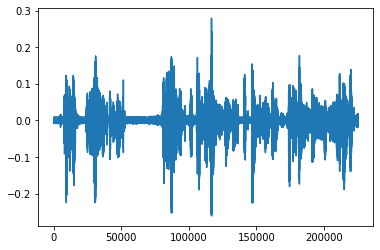

In [11]:
# show the graph
waveform, sample_rate = torchaudio.load("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac", normalization=True)

plt.plot(waveform.t())

### Computing the mfcc features

torch.Size([1, 10, 1127])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


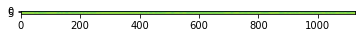

In [13]:
# compute mfcc
mfcc = torchaudio.transforms.MFCC(n_mfcc=10, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

In [ ]:
#torchaudio.transforms.FrequencyMasking()
#torchaudio.transforms.TimeMasking()

TypeError: ignored

In [7]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')


train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


then

In [8]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

optimizer

In [10]:
from torch import optim 

In [11]:
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=hparams['learning_rate'],
	steps_per_epoch=int(len(train_loader)),
	epochs=hparams['epochs'],
	anneal_strategy='linear')

NameError: ignored

In [12]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

last step

In [ ]:
#libri_data = torchaudio.datasets.LIBRISPEECH('./', download=True)
#vctk_data = torchaudio.datasets.VCTK_092('./', download=True)

NotImplementedError: ignored

Then built based on the 


speaker features:
https://github.com/jameslyons/python_speech_features

https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/

In [ ]:
#GMM
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc

def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
              first =0
            else:
              first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feature = mfcc.mfcc(audio,rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

SyntaxError: ignored

Authencation process

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

https://discuss.pytorch.org/t/how-to-save-model-weights-to-local-machine-from-colab/33318/2

save models

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode


## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html


In [14]:
class SpeechEmbedder(nn.Module):
    
    def __init__(self):
      # super avoid call the 
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(hp.data.nmels, hp.model.hidden, num_layers=hp.model.num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            #Fills the input Tensor with values according to the method 
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hp.model.hidden, hp.model.proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

## using Generalized end to end loss function. 
class GE2ELoss(nn.Module):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0).to(device), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(-5.0).to(device), requires_grad=True)
        self.device = device
    
    def forward(self, embeddings):
        torch.clamp(self.w, 1e-6)
        centroids = get_centroids(embeddings)
        cossim = get_cossim(embeddings, centroids)
        sim_matrix = self.w*cossim.to(self.device) + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss


In [15]:

## based on computer vision product
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

NameError: ignored

# Fresh Start 

Here I use the pytorch lighting model

In [16]:
class SpeechEmbedder(pl.LightningModule):
    
    def __init__(self):
      # super avoid call the 
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(hp.data.nmels, hp.model.hidden, num_layers=hp.model.num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            #Fills the input Tensor with values according to the method 
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hp.model.hidden, hp.model.proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

In [17]:
## using Generalized end to end loss function. 
class GE2ELoss(pl.LightningModule):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0).to(device), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(-5.0).to(device), requires_grad=True)
        self.device = device
    
    def forward(self, embeddings):
        torch.clamp(self.w, 1e-6)
        centroids = get_centroids(embeddings)
        cossim = get_cossim(embeddings, centroids)
        sim_matrix = self.w*cossim.to(self.device) + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss

DataLoad

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

class LitModel(LightningModule):

    def train_dataloader(self):
        concat_dataset = ConcatDataset(
            datasets.ImageFolder(traindir_A),
            datasets.ImageFolder(traindir_B)
        )

        loader = torch.utils.data.DataLoader(
            concat_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.workers,
            pin_memory=True
        )
        return loader

    def val_dataloader(self):
        # SAME
        ...

    def test_dataloader(self):
        # SAME
        ...

In [ ]:
class MyDataModule(LightningDataModule):

    def __init__(self):
        super().__init__()
        self.train_dims = None
        self.vocab_size = 0

    def prepare_data(self):
        # called only on 1 GPU
        download_dataset()
        tokenize()
        build_vocab()

    def setup(self):
        # called on every GPU
        vocab = load_vocab()
        self.vocab_size = len(vocab)

        self.train, self.val, self.test = load_datasets()
        self.train_dims = self.train.next_batch.size()

    def train_dataloader(self):
        transforms = ...
        return DataLoader(self.train, batch_size=64)

    def val_dataloader(self):
        transforms = ...
        return DataLoader(self.val, batch_size=64)

    def test_dataloader(self):
        transforms = ...
        return DataLoader(self.test, batch_size=64)

In [ ]:
libri_train
libri_val
libri_test

In [ ]:
def prepare_data(self):
  ##prepare transform to dataset
  

## training

code

In [ ]:
# defining global variable path
# Location of my dataset on My Google Drive
file_path = "/content/drive/MyDrive/TIMIT/TRAIN"
import tensorflow as tf

def loadFiles(path):
    '''Put files into lists and return them as one list with all files 
     in the folder'''
    wav_files = sorted([os.path.join(path, 'train', file)
                          for file in os.listdir(path + "/train")
                          if file.endswith('.wav')])
    return file_path


In [ ]:
### example 
'''
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set, experiment)

'''

In [ ]:
from torch.utils.data import DataLoader

from data_load import SpeakerDatasetTIMIT, SpeakerDatasetTIMITPreprocessed
from speech_embedder_net import SpeechEmbedder, GE2ELoss, get_centroids, get_cossim

def train(model_path):
    device = torch.device(hp.device)
    
    if hp.data.data_preprocessed:
        train_dataset = SpeakerDatasetTIMITPreprocessed()
    else:
        train_dataset = SpeakerDatasetTIMIT()
    train_loader = DataLoader(train_dataset, batch_size=hp.train.N, shuffle=True, num_workers=hp.train.num_workers, drop_last=True) 
    
    embedder_net = SpeechEmbedder().to(device)
    if hp.train.restore:
        embedder_net.load_state_dict(torch.load(model_path))
    ge2e_loss = GE2ELoss(device)
    #Both net and loss have trainable parameters
    optimizer = torch.optim.SGD([
                    {'params': embedder_net.parameters()},
                    {'params': ge2e_loss.parameters()}
                ], lr=hp.train.lr)
    
    os.makedirs(hp.train.checkpoint_dir, exist_ok=True)
    
    embedder_net.train()
    iteration = 0
    for e in range(hp.train.epochs):
        total_loss = 0
        for batch_id, mel_db_batch in enumerate(train_loader): 
            mel_db_batch = mel_db_batch.to(device)
            
            mel_db_batch = torch.reshape(mel_db_batch, (hp.train.N*hp.train.M, mel_db_batch.size(2), mel_db_batch.size(3)))
            perm = random.sample(range(0, hp.train.N*hp.train.M), hp.train.N*hp.train.M)
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
            mel_db_batch = mel_db_batch[perm]
            #gradient accumulates
            optimizer.zero_grad()
            
            embeddings = embedder_net(mel_db_batch)
            embeddings = embeddings[unperm]
            embeddings = torch.reshape(embeddings, (hp.train.N, hp.train.M, embeddings.size(1)))
            
            #get loss, call backward, step optimizer
            loss = ge2e_loss(embeddings) #wants (Speaker, Utterances, embedding)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(embedder_net.parameters(), 3.0)
            torch.nn.utils.clip_grad_norm_(ge2e_loss.parameters(), 1.0)
            optimizer.step()
            
            total_loss = total_loss + loss
            iteration += 1
            if (batch_id + 1) % hp.train.log_interval == 0:
                mesg = "{0}\tEpoch:{1}[{2}/{3}],Iteration:{4}\tLoss:{5:.4f}\tTLoss:{6:.4f}\t\n".format(time.ctime(), e+1,
                        batch_id+1, len(train_dataset)//hp.train.N, iteration,loss, total_loss / (batch_id + 1))
                print(mesg)
                if hp.train.log_file is not None:
                    with open(hp.train.log_file,'a') as f:
                        f.write(mesg)
                    
        if hp.train.checkpoint_dir is not None and (e + 1) % hp.train.checkpoint_interval == 0:
            embedder_net.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e+1) + "_batch_id_" + str(batch_id+1) + ".pth"
            ckpt_model_path = os.path.join(hp.train.checkpoint_dir, ckpt_model_filename)
            torch.save(embedder_net.state_dict(), ckpt_model_path)
            embedder_net.to(device).train()

    #save model
    embedder_net.eval().cpu()
    save_model_filename = "final_epoch_" + str(e + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
    save_model_path = os.path.join(hp.train.checkpoint_dir, save_model_filename)
    torch.save(embedder_net.state_dict(), save_model_path)
    
    print("\nDone, trained model saved at", save_model_path)

def test(model_path):
    
    if hp.data.data_preprocessed:
        test_dataset = SpeakerDatasetTIMITPreprocessed()
    else:
        test_dataset = SpeakerDatasetTIMIT()
    test_loader = DataLoader(test_dataset, batch_size=hp.test.N, shuffle=True, num_workers=hp.test.num_workers, drop_last=True)
    
    embedder_net = SpeechEmbedder()
    embedder_net.load_state_dict(torch.load(model_path))
    embedder_net.eval()
    
    avg_EER = 0
    for e in range(hp.test.epochs):
        batch_avg_EER = 0
        for batch_id, mel_db_batch in enumerate(test_loader):
            assert hp.test.M % 2 == 0
            enrollment_batch, verification_batch = torch.split(mel_db_batch, int(mel_db_batch.size(1)/2), dim=1)
            
            enrollment_batch = torch.reshape(enrollment_batch, (hp.test.N*hp.test.M//2, enrollment_batch.size(2), enrollment_batch.size(3)))
            verification_batch = torch.reshape(verification_batch, (hp.test.N*hp.test.M//2, verification_batch.size(2), verification_batch.size(3)))
            
            perm = random.sample(range(0,verification_batch.size(0)), verification_batch.size(0))
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
                
            verification_batch = verification_batch[perm]
            enrollment_embeddings = embedder_net(enrollment_batch)
            verification_embeddings = embedder_net(verification_batch)
            verification_embeddings = verification_embeddings[unperm]
            
            enrollment_embeddings = torch.reshape(enrollment_embeddings, (hp.test.N, hp.test.M//2, enrollment_embeddings.size(1)))
            verification_embeddings = torch.reshape(verification_embeddings, (hp.test.N, hp.test.M//2, verification_embeddings.size(1)))
            
            enrollment_centroids = get_centroids(enrollment_embeddings)
            
            sim_matrix = get_cossim(verification_embeddings, enrollment_centroids)
            
            # calculating EER
            diff = 1; EER=0; EER_thresh = 0; EER_FAR=0; EER_FRR=0
            
            for thres in [0.01*i+0.5 for i in range(50)]:
                sim_matrix_thresh = sim_matrix>thres
                
                FAR = (sum([sim_matrix_thresh[i].float().sum()-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(hp.test.N))])
                /(hp.test.N-1.0)/(float(hp.test.M/2))/hp.test.N)
    
                FRR = (sum([hp.test.M/2-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(hp.test.N))])
                /(float(hp.test.M/2))/hp.test.N)
                
                # Save threshold when FAR = FRR (=EER)
                if diff> abs(FAR-FRR):
                    diff = abs(FAR-FRR)
                    EER = (FAR+FRR)/2
                    EER_thresh = thres
                    EER_FAR = FAR
                    EER_FRR = FRR
            batch_avg_EER += EER
            print("\nEER : %0.2f (thres:%0.2f, FAR:%0.2f, FRR:%0.2f)"%(EER,EER_thresh,EER_FAR,EER_FRR))
        avg_EER += batch_avg_EER/(batch_id+1)
    avg_EER = avg_EER / hp.test.epochs
    print("\n EER across {0} epochs: {1:.4f}".format(hp.test.epochs, avg_EER))
        
if __name__=="__main__":
    if hp.training:
        train(hp.model.model_path)
    else:
        test(hp.model.model_path)

ModuleNotFoundError: ignored

## saving model

check: https://pytorch-lightning.readthedocs.io/en/stable/weights_loading.html

In [ ]:
# saves checkpoints to '/your/path/to/save/checkpoints' at every epoch end
trainer = Trainer(default_root_dir='/your/path/to/save/checkpoints')

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

class LitAutoEncoder(pl.LightningModule):
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)

        # 1. calculate loss
        loss = F.cross_entropy(y_hat, y)

        # 2. log `val_loss`
        self.log('val_loss', loss)

# 3. Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor='val_loss')

# 4. Add your callback to the callbacks list
trainer = Trainer(callbacks=[checkpoint_callback])

# Performance Check

Plan to use a goodgle dataset

In [ ]:
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls